In [1]:
import pandas as pd
import nltk
import spacy
import sys
import os

C:\Users\mathe\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
PROJECT_BASE_PATH = 'C:\\projects\\a3_test'
DATA_BASE_PATH = os.path.join(PROJECT_BASE_PATH, 'data')
SPACY_MODEL = 'en_core_web_md'

sys.path.append(PROJECT_BASE_PATH)

In [ ]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
## Defining our custom functions

from src.preprocessing.text import normalize_text, remove_noisy_texts, add_textual_statistics
from src.preprocessing.reports import duplicated_report, missing_values_report
from src.analysis.companies import detect_company_name
from src.utils import printmd

from src.modeling.cluster import KPipeline
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

## Modeling 🧠💡📊

In this topic, we will leverage SciKit Learn to analyze our corpus using clusterization. By employing cluster analysis, we can uncover valuable insights regarding the composition of clusters and effectively reduce the dimensionality of the data. PyCaret provides a comprehensive set of tools and techniques that facilitate the exploration, evaluation, and interpretation of clusters, enabling us to gain a deeper understanding of our dataset. Through this approach, we aim to extract meaningful patterns and structures within the data, which can inform decision-making processes and unlock hidden insights.

For our experiment we will try 1:
   * KMeans Clusterization with word2vec

## Clusterization by KMeans

In [ ]:
data = pd.read_csv(os.path.join(DATA_BASE_PATH, 'curated', 'featured.csv'))

In [ ]:
data.sample(3)

### Text Preprocessing

First lets preprocess our text, removing stopwords, and lemmatizing our text to avoid bias and reduce the data complexity.

In [ ]:
pipeline = KPipeline()

In [ ]:
preprocessed_text = pipeline.preprocess_text(data['desc'])

In [ ]:
preprocessed_text[0]

In [ ]:
from wordcloud import WordCloud

Lets show a wordcloud to understand better which words are more present on the preprocessed text

In [ ]:
# Generate a word cloud image
wordcloud = WordCloud(
    width=1200, height=700
).generate(' '.join(preprocessed_text))

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Now lets vectorize our preprocessed to text to input in a model, instead of using populars approaches like TFIDF and BOW lets use Word2Vec, thats can gather semantic correlations between the words.

### Word2Vec

In [ ]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from gensim.models import KeyedVectors
from gensim.models.phrases import Phrases, Phraser
import time

Lets prepare our data for Word2Vec model

### Bigram data

The following process helps capture multi-word expressions and can improve the quality of subsequent analyses, such as topic modeling or word embeddings. In this case we will use it to automatically capture most commom phrases from sentences, they also form a bigram.

In [ ]:
sent = [row.split() for row in preprocessed_text]
phrases = Phrases(sent, min_count=30, progress_per=10000)
bigram = Phraser(phrases)
sentences = bigram[sent]

In [18]:
sentences

In [ ]:
from collections import Counter

# Flatten the list of lists into a single list
all_words = [word for sublist in sentences for word in sublist]

# Count the frequency of each word
word_counts = Counter(all_words)

# Sort the word counts in descending order
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted_counts[:10]

In [ ]:
sorted_counts[-10:]

Below we can check the most commons bigrams

In [ ]:
list(phrases.find_phrases(sent).items())[:10]

### Build the model

In [51]:
w2v_model = Word2Vec(min_count=30,
                     window=10,
                     vector_size=50,
                     workers=4)

INFO - 23:01:45: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=50, alpha=0.025>', 'datetime': '2023-05-21T23:01:45.422510', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'created'}


#### Vocab

In [52]:
w2v_model.build_vocab(sentences, progress_per=10000)

INFO - 23:01:47: collecting all words and their counts
INFO - 23:01:47: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 23:01:47: collected 20235 word types from a corpus of 205100 raw words and 3452 sentences
INFO - 23:01:47: Creating a fresh vocabulary
INFO - 23:01:47: Word2Vec lifecycle event {'msg': 'effective_min_count=30 retains 1000 unique words (4.94% of original 20235, drops 19235)', 'datetime': '2023-05-21T23:01:47.563799', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 23:01:47: Word2Vec lifecycle event {'msg': 'effective_min_count=30 leaves 150259 word corpus (73.26% of original 205100, drops 54841)', 'datetime': '2023-05-21T23:01:47.563799', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 23:01:47: del

In [53]:
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

INFO - 23:01:49: Word2Vec lifecycle event {'msg': 'training model with 4 workers on 1000 vocabulary and 50 features, using sg=0 hs=0 sample=0.001 negative=5 window=10 shrink_windows=True', 'datetime': '2023-05-21T23:01:49.006043', 'gensim': '4.3.1', 'python': '3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'train'}
INFO - 23:01:49: EPOCH 0: training on 205100 raw words (107534 effective words) took 0.4s, 289740 effective words/s
INFO - 23:01:49: EPOCH 1: training on 205100 raw words (107364 effective words) took 0.3s, 318131 effective words/s
INFO - 23:01:50: EPOCH 2: training on 205100 raw words (107368 effective words) took 0.3s, 327016 effective words/s
INFO - 23:01:50: EPOCH 3: training on 205100 raw words (107291 effective words) took 0.3s, 345174 effective words/s
INFO - 23:01:50: EPOCH 4: training on 205100 raw words (107308 effective words) took 0.3s, 357522 effective words/s
INFO - 23:01:51: EPOCH 5: train

(3222856, 6153000)

### Lets Analysize

Lets check in our word2vec models some words similarity

In [54]:
w2v_model.wv.most_similar(positive=["industry"])

[('innovation', 0.569883406162262),
 ('market', 0.5127063393592834),
 ('sector', 0.48545601963996887),
 ('manufacturing', 0.464173287153244),
 ('government', 0.4237501323223114),
 ('category', 0.42142608761787415),
 ('firm', 0.4196717441082001),
 ('industrial', 0.415778785943985),
 ('financial_service', 0.41200780868530273),
 ('real_estate', 0.40069979429244995)]

In [55]:
w2v_model.wv.most_similar(positive=["health"])

[('population', 0.6291395425796509),
 ('health_care', 0.6218021512031555),
 ('healthcare', 0.6210702061653137),
 ('wellness', 0.5459017753601074),
 ('mental_health', 0.5440821647644043),
 ('mental', 0.5409170389175415),
 ('family', 0.5405942797660828),
 ('Health', 0.5394222736358643),
 ('health_plan', 0.536107063293457),
 ('behavioral', 0.5296799540519714)]

In [ ]:
w2v_model.wv.most_similar(positive=["security"])

In [ ]:
w2v_model.wv.most_similar(positive=["big_datum"])

In [ ]:
w2v_model.wv.most_similar(positive=["doctor"])

As we can see above there, the model is correlating near terms and their semantic significancy.

### Analogies

Lets try to check if our wav2vec model can make some analogies

*What word is to doctor as company is to developer?*

In [62]:
w2v_model.wv.most_similar(positive=["doctor", "company"], negative=["developer"], topn=4)

[('healthcare_provider', 0.6101425886154175),
 ('clinic', 0.5275355577468872),
 ('medical', 0.5180250406265259),
 ('health_care', 0.4670306146144867)]

In [63]:
from src.analysis.text import tsnescatterplot

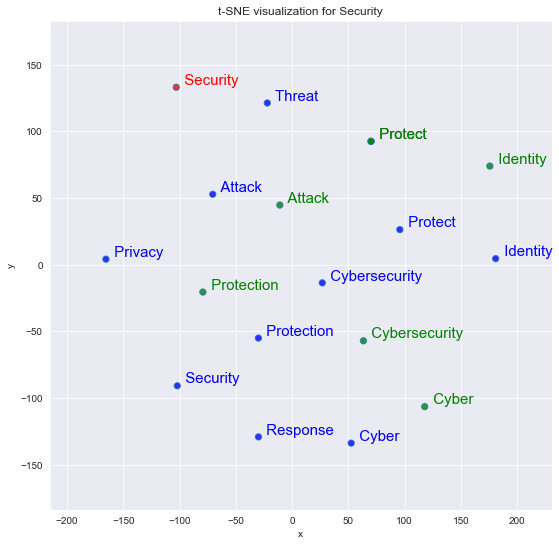

In [64]:
tsnescatterplot(w2v_model, 'security', ['protect', 'cybersecurity', 'protection', 'protect', 'attack', 'cyber', 'identity'])

As we can see, the security term is highly associated with others security terms, teir near of then in their spatial proximity.

In [65]:
len(preprocessed_text)

3452

### Training Pipeline

Lets create our Pipeline to vectorize with word2vec.

Base on the previous analysis, the kmeans model will have 4 cluster.

Based on Security, Manufacture, Health and Marketing industries.

In [66]:
from tqdm import tqdm
from src.modeling.cluster import KPipeline
import numpy as np

In [69]:
pipeline = KPipeline()

In [71]:
vectors = pipeline.prepare(df=data, text_column='desc', w2v_model=w2v_model)

INFO - 23:05:01: Preprocessing texts...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3452/3452 [00:00<00:00, 19392.01it/s]
INFO - 23:05:45: Vectorizing the texts...


In [72]:
clustering = pipeline.mbkmeans_clusters(
    k=6,
    mb=500,
    print_silhouette_values=True
)

C:\Users\mathe\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mathe\AppData\Roaming\Python\Python38\site-packages\sklearn\cluster\_kmeans.py:1902: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=2
  warnings.warn(


For n_clusters = 6
Silhouette coefficient: 0.19
Inertia:3030.409473241688
Silhouette values:
    Cluster 4: Size:369 | Avg:0.42 | Min:0.05 | Max: 0.61
    Cluster 1: Size:1095 | Avg:0.24 | Min:-0.19 | Max: 0.47
    Cluster 2: Size:1081 | Avg:0.23 | Min:-0.10 | Max: 0.47
    Cluster 0: Size:18 | Avg:0.08 | Min:-0.33 | Max: 0.36
    Cluster 5: Size:469 | Avg:0.01 | Min:-0.22 | Max: 0.27
    Cluster 3: Size:420 | Avg:-0.00 | Min:-0.28 | Max: 0.26


Lets check which words more represents each cluster

In [86]:
print("Most representative terms per cluster (based on centroids):")
for i in range(4):
    tokens_per_cluster = ""
    most_representative = w2v_model.wv.most_similar(positive=[clustering.cluster_centers_[i]], topn=5)
    for t in most_representative:
        tokens_per_cluster += f"{t[0]} "
    print(f"Cluster {i}: {tokens_per_cluster}")

Most representative terms per cluster (based on centroids):
Cluster 0: s want love ! happy 
Cluster 1: s love want ! earn 
Cluster 2: s love want ! happy 
Cluster 3: s . ! month earn 


In [74]:
test_cluster = 1
most_representative_docs = np.argsort(
    np.linalg.norm(vectors - clustering.cluster_centers_[test_cluster], axis=1)
)
for d in most_representative_docs[:3]:
    print(data['desc'][d])
    print("-------------")

Cin7 inventory management software is the smartest way for growing brands to sell more to more customers in more places. With extensive integration and workflow automation, Cin7 makes it easy to optimize inventory, manage orders, and maximize margins for every location and every sales channel that matters to you. Cin7 includes built-in POS,warehouse management and B2B eCommerce features, and built-in EDI for selling to major retailers around the world. Cin7 also integrates with online marketplaces, 3PL warehouses, as well as accounting, sales and marketing, inventory forecasting and other solutions you use to run your business. Visit Cin7.com for more information.
-------------
Amelia is a computer software company that offers an app that helps employees develop mental health habits with breathing, meditation, and yoga.It syncs with popular wearable devices like Apple Watch or Fitbit to suggest data-driven recommendations unique to each person. Also, it provides an analytics dashboard 

In [75]:
data['cluster_label'] = clustering.labels_

### Distribution

Distribution of companies by clusters

<Axes: >

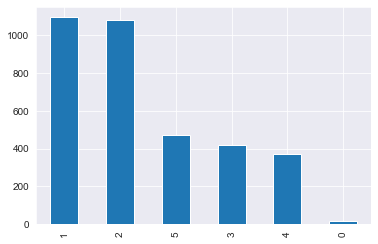

In [88]:
data['cluster_label'].value_counts().plot.bar()

In [85]:
data[data['cluster_label'] == 0].sample(5).to_dict(orient='records')

[{'id': '1ac1c877-462a-47a4-b002-79a01899c229',
  'desc': 'Sherpa is a last mile courier market place. Through SherpaFleet; a delivery and driver management software as a service platform (SaaS) we help businesses manage their fleets and access the inventory from other fleets and including sharing their own.This creates a more efficient and effective last mile solution for businesses overalldisrupting the principle of owning the driver.',
  'text_length': 381,
  'num_sentences': 3,
  'token_count': 64,
  'text_length_outlier_bound': 'no_outlier',
  'num_sentences_outlier_bound': 'no_outlier',
  'token_count_outlier_bound': 'no_outlier',
  'name': 'Sherpa ',
  'cluster_label': 0},
 {'id': '9d39a3bd-0e0c-4067-9595-8f09cee9522a',
  'desc': 'Persado is the Marketing Language Cloud; AI generated language that resonates the most with any audience, segment or individual. Imagine having a data scientist and a copywriter for each person in your audience; you get the language that performs and t

In [80]:
df = data.copy()

df['desc_norm'] = preprocessed_text

In [81]:
import pandas as pd
from collections import Counter

# Assuming your original dataset is a Pandas DataFrame called 'df'
# 'desc' column contains the descriptions and 'cluster_label' column contains the cluster labels

# Create an empty DataFrame to store the results
top_words_df = pd.DataFrame(columns=['cluster_label', 'word', 'frequency'])

# Get the unique cluster labels in the dataset
unique_clusters = df['cluster_label'].unique()

# Iterate over each cluster label and find the top 10 most frequent words
for cluster_label in unique_clusters:
    # Filter the DataFrame for the current cluster
    cluster_df = df[df['cluster_label'] == cluster_label]
    
    # Concatenate all the descriptions for the current cluster
    descriptions = ' '.join(cluster_df['desc_norm'].tolist())
    
    # Split the text into individual words
    words = descriptions.split()
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Get the top 10 most frequent words
    top_words = word_counts.most_common(10)
    
    # Create a DataFrame for the current cluster's top words
    cluster_top_words_df = pd.DataFrame(top_words, columns=['word', 'frequency'])
    cluster_top_words_df['cluster_label'] = cluster_label
    
    # Append the current cluster's top words DataFrame to the overall top words DataFrame
    top_words_df = pd.concat([top_words_df, cluster_top_words_df], ignore_index=True)

# Sort the DataFrame by cluster_label and frequency
top_words_df = top_words_df.sort_values(by=['cluster_label', 'frequency'], ascending=[True, False])

# Print the top 10 most frequent words by cluster_label
for cluster_label in unique_clusters:
    cluster_words_df = top_words_df[top_words_df['cluster_label'] == cluster_label]
    print(f"Cluster {cluster_label}:")
    print(cluster_words_df.head(10))
    print()

Cluster 5:
  cluster_label        word frequency
0             5           ,      2100
1             5           -      1768
2             5           .      1630
3             5           (       315
4             5           )       306
5             5     company       299
6             5    platform       264
7             5        base       211
8             5  technology       187
9             5       datum       174

Cluster 1:
   cluster_label        word frequency
10             1           ,      8775
11             1           .      4473
12             1           -      1639
13             1     company       808
14             1    platform       661
15             1       datum       538
16             1     provide       451
17             1    customer       407
18             1  technology       393
19             1     service       392

Cluster 3:
   cluster_label      word frequency
20             3         ,      2959
21             3         .      1361
22     

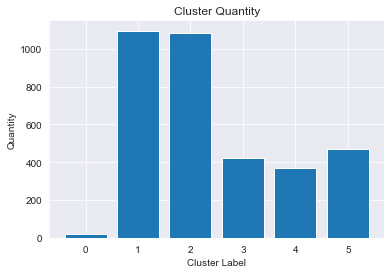

In [89]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is a Pandas DataFrame called 'df'
# 'cluster_label' column contains the cluster labels

# Count the number of instances in each cluster
cluster_counts = df['cluster_label'].value_counts()

# Create a bar plot to visualize the cluster quantity
plt.bar(cluster_counts.index, cluster_counts.values)

# Set labels and title for the plot
plt.xlabel('Cluster Label')
plt.ylabel('Quantity')
plt.title('Cluster Quantity')

# Display the plot
plt.show()

## Conclusions

Cluster 0: This cluster has a relatively lower frequency of punctuation marks and terms like 'company' and 'platform.' It includes terms like 'service,' 'solution,' 'datum,' and 'enable.' This cluster might represent descriptions emphasizing services, solutions, and data-enabled capabilities.

Cluster 1: Similar to Cluster 5, this cluster also has frequent punctuation marks (',' and '.') and terms like 'company,' 'platform,' and 'technology.' However, it has a higher frequency of terms like 'provide,' 'customer,' and 'service.' This cluster might represent descriptions of companies providing technology services or platforms.

Cluster 2: This cluster also contains punctuation marks (',' and '.'), along with terms like 'company,' 'platform,' and 'service.' It has a relatively higher frequency of terms like 'business' and 'solution.' This cluster might represent descriptions of companies or platforms providing business solutions and services.

Cluster 3: This cluster also contains punctuation marks (',' and '.'), along with terms like 'company,' 'platform,' and 'provide.' It has a relatively higher frequency of the term 'found.' This cluster might represent descriptions of companies or platforms focused on founding or establishing something.

Cluster 4: Similar to other clusters, this one includes punctuation marks (',' and '.'), along with terms like 'company' and 'platform.' It has a higher frequency of terms like 'business,' 'solution,' and 'customer.' This cluster might represent descriptions of companies or platforms offering business solutions and targeting customers.

Cluster 5: The most frequent words in this cluster include punctuation marks (',' and '.'), along with common terms like 'company,' 'platform,' and 'technology.' This cluster might represent descriptions related to technology companies or platforms.


In conclusion, Word2Vec embeddings have proven to be valuable in capturing semantic relationships and similarities between words in text data. The embeddings enable various operations, such as word analogies and measuring text similarity, which offer insights into the underlying semantic structure of the data. However, when applying K-means clustering to short descriptions for sector segmentation, the results may not meet expectations due to certain factors. Insufficient or inconsistent data quality, inadequate representation of sector-specific information in the embeddings, and an incorrect number of clusters are potential reasons for suboptimal clustering outcomes. Additionally, the limited amount of data may impact the effectiveness of the K-means algorithm. Exploring alternative feature representations, considering other relevant features, and evaluating the clustering results with domain knowledge are recommended steps to enhance sector-based clustering accuracy.